# Optimal Transport between 1-D signals and binned pointclouds

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import matplotlib

from scipy.spatial.distance import euclidean
from scipy import interpolate 
from tslearn.metrics import dtw_path

## Optimal transport between 1-D signals

Use the $L^2$ distance as a distance between source and target; this is a strictly convex function, so can use the north-west corner method to immediately give a unique optimal solution. Complexity only $O(n + m -1)$, where m, n are the lengths of the signals respectively. 

In [2]:
def _normalise(source, target):
    return np.divide(source, np.sum(source))

In [3]:
def _optimaltransport(source, target):

    # normalise densities to have equal sum. Integers for ease.
    
    if len(source) == 0:
        mapping, cost = np.zeros((1,1)), 0.000001
        return mapping, cost
    
    source, target = np.array(source), np.array(target)
    f_x, g_y = _normalise(source, target), _normalise(target, source)
    
    if len(f_x) == 1:
        m, n = 100000000, len(g_y)
    else:        
        m, n = len(f_x), len(g_y)
       
    c, i, j = 0, 0, 0
    
    mapping = np.zeros((m, n)) # Can create heatmap to visualise mapping. Only for small m, n! Or use sparse matrix

    while i < m and j < n:
        if g_y[j] == 0: 
            j += 1
        elif f_x[i] == 0: # if supply/demand if empty, skip. 
            i += 1
        else:
            if f_x[i] - g_y[j] > 0:
                f_x[i] -= g_y[j]
                c += (i/(m-1) - j/(n-1)) ** 2 * g_y[j] # density * cost to transport
                mapping[i,j] = g_y[j]
                j += 1
            elif f_x[i] - g_y[j] < 0:
                g_y[j] -= f_x[i]
                c += (i/(m-1) - j/(n-1)) ** 2 * f_x[i] # density * cost to transport
                mapping[i,j] = f_x[i]
                i += 1
            else: 
                c += (i/(m-1) - j/(n-1)) ** 2 * f_x[i] # density * cost to transport
                mapping[i,j] = f_x[i]
                i += 1                
                j += 1
    
    return mapping, c

## Example/test to see if optimal transport algorithm works

Optimal transport between source and target $f(x) = x$,  $g(y) = (1 - y)$ respectively for $x, y, \in [0, 1]$. Should produce a mapping of a quarter circle. 

In [4]:
m, n = 128, 128

source = np.array(list(reversed(range(m)))) / m
target = np.array(list(range(n))) / n

In [5]:
mapping, cost = _optimaltransport(source, target)


Transport cost: 0.12233847991318028



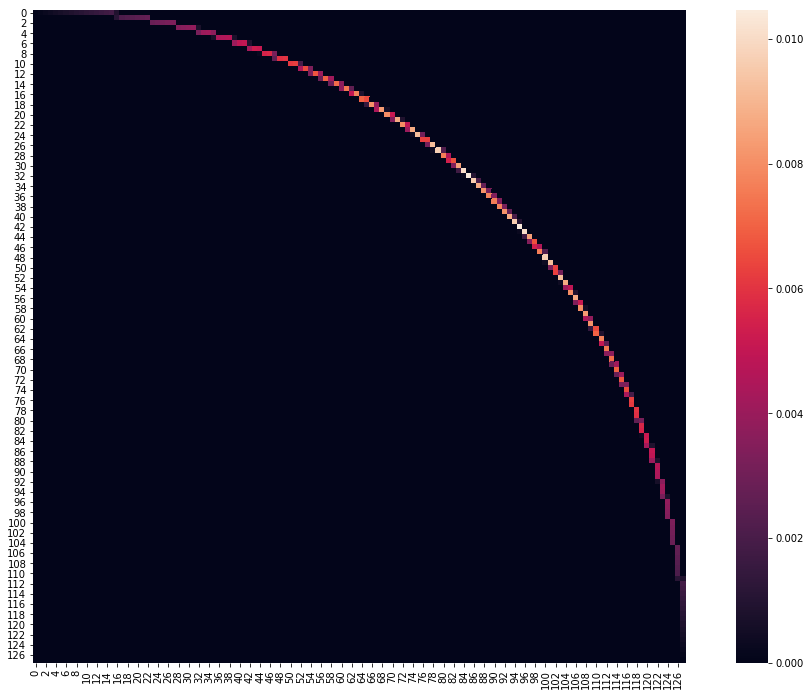

In [6]:
plt.gcf().set_size_inches(18,12)
plt.gca().set_aspect('equal')
print('\n' + 'Transport cost: ' + str(cost) + '\n')
sns.heatmap(mapping)

## Functions for splitting signal based on Dynamic Time Warping

In [7]:
def _partition_current(ts, template, t_points, dtw_envelope_size=6):
    """
    Identifies the mapping points between two functions using dynamic time warping.
    :param ts: the time series at which the mapping points will be identified
    :param template: the template series
    :param t_points: the points of interest
    :return: the indices of the points found on the ts
    """
    # Normalize template and ts
    template = (template - min(template)) / float(max(template))
    ts = (ts - min(ts)) / float(max(ts))
    # Run DTW algorithm and get the mapping points
    point_mappings = np.array(dtw_path(
        ts, template, global_constraint='sakoe_chiba', sakoe_chiba_radius=dtw_envelope_size)[0])
    mapped_points = []
    for p in t_points:
        mapped_points.append(
            point_mappings[np.where(point_mappings[:, 0] == p)][0][1])
    return mapped_points


## Example similar signal

In [8]:
a = 1
b = 0.2
c = 0.1

x = np.array(list(range(100))) / float(100)

f = a*np.exp(-(x - b)**2 / (2*c**2))
g = a*np.exp(-(x-1.2*b)**2 / (2*c**2))


Two Gaussians: 



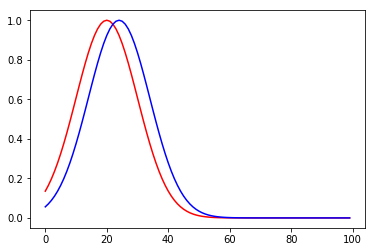

In [9]:
# example of template and normal flip

plt.plot(f, color='r')
plt.plot(g, color='b')
print('\n' + 'Two Gaussians: ' + '\n')


## Find bin partitions based on DTW

In [10]:
t_points = [1, 25, 60, 90]
dtw_envelope_size = 6

# partition resampled signals

partitions = _partition_current(f, g, [1, 25, 60, 90], dtw_envelope_size)
print(partitions)

[5, 29, 64, 95]


In [11]:
def _plotting(x1, x2):
    plt.plot(np.array(list(range(100))) / 100.0, x1)
    print('\n' + 'Gauss1: ' + '\n')
    for p in t_points:
        plt.axvline(p / 100.0, color='r')
    plt.show()

    plt.plot(np.array(list(range(100))) / 100.0, x2)
    for p in t_points:
        plt.axvline(p / 100.0, color='r')
    print('\n' + 'Gauss2')


Gauss1: 



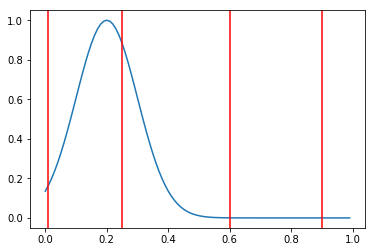


Gauss2


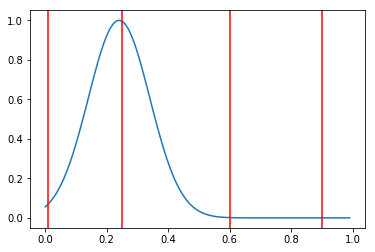

In [12]:
_plotting(f, g)

## Function to compute optimal transport between all bins

In [13]:
# function takes two signals and splits it into $k$ bins, based on dynamic time warping.
# Computes optimal transport distance between each of the bins of interest. Idea is that we can spot 
# discrepancies in certain parts of the signal which can be used as features.

def _PointCloud(x1, x2, t_points, partitions):
    bin_no = len(t_points)
    feature_vector = []
    feature_vector.append(_optimaltransport(x1, x2)[1])
    
    for i in range(1, bin_no):
        source = x1[partitions[i-1]:partitions[i]]
        target = x2[t_points[i-1]:t_points[i]]
        feature_vector.append(_optimaltransport(source, target)[1])
      
    return feature_vector 

## Pipeline

In [14]:
def _PointCloudOT(x1, x2, t_points = [1, 25, 60, 90], dtw_window_size = 6):
    partitions = _partition_current(x1, x2, t_points, dtw_envelope_size)
    feature_vector = _PointCloud(x1, x2, partitions, t_points)
    transport_sum = np.sum(feature_vector[1:])
   
    return feature_vector


In [15]:
_PointCloudOT(f, g)

[0.0014305809209518142,
 2.8431101203627445e-18,
 6.780355128187922e-18,
 1.0518723113795901e-05]

Low distances!

## Example of different signal 

In [16]:
a = 1
b = 0.2
c = 0.1

x = np.array(list(range(100))) / float(100)

f = a*np.exp(-(x - b)**2 / (2*c**2)) + a*np.exp(-(x - 4*b)**2 / (2*c**2))
g = a*np.exp(-(x-2.5*b)**2 / (2*c**2))

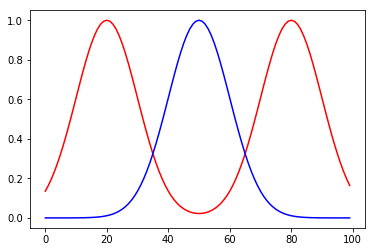

In [17]:
plt.plot(f, color='r')
plt.plot(g, color='b')


In [18]:
t_points = [1, 25, 60, 90]
dtw_envelope_size = 6

# partition resampled signals

partitions = _partition_current(f, g, [1, 25, 60, 90], dtw_envelope_size)
print(partitions)

[7, 31, 65, 84]



Gauss1: 



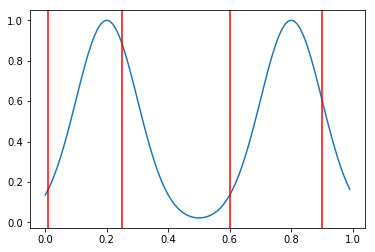


Gauss2


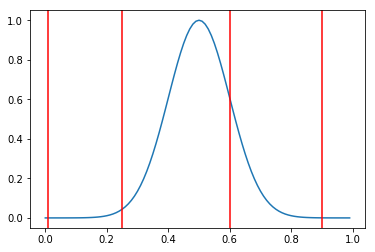

In [19]:
_plotting(f, g)

In [20]:
_PointCloudOT(f, g)

[0.04885124266945425,
 0.06978762157215912,
 0.12295912685970561,
 0.16215003373256406]

Much higher distances! 